# Generative Adversarial Networks #


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(1)

In [2]:
from tensorflow.keras.datasets import fashion_mnist

# load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
# expand dimensions and normalize the images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [4]:
BATCH_SIZE = 64

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1, 28, 28, 1))

# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# the generator's input is a noise vector
# hyper-parameter that also requires fine-tuning
NOISE_DIM = 150

# design a generator model with upsampling layers
# in GANs practices, usually the generator has leaky relu activation while the discriminator has relu
generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

In [6]:
# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [7]:
# set different learning rates for the generator and the discriminator
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [8]:
# observe the annotation allows for efficient native tensoflow compiling
@tf.function
def trainDStep(data):
  # the batch is (32,28,28,1), so extract 32 value
  batchSize = tf.shape(data)[0]
  # create a noise vector as generator input sampled from Gaussian Random Normal
  # As an exercise try sampling from a uniform distribution and observe the difference
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatenate the real and fake labels
  y_true = tf.concat(
    [
      # the original data is real, labeled with 1
      tf.ones(batchSize, 1),
      # the forged data is fake, labeled with 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    # generate forged samples
    fake = generator(noise)
    # concatenate real data and forged data
    x = tf.concat([data, fake], axis=0)
    # see if the discriminator detects them
    y_pred = discriminator(x)
    # calculate the loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # apply the backward path and update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # report accuracy
  dAccMetric.update_state(y_true, y_pred)

  # return the loss for visualization
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [9]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # when training the generator, we want it to maximize the probability that its output is classified as real
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [10]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

E:0, Loss G:0.6633, Loss D:0.5383, Acc G:%0.49, Acc D:%91.11


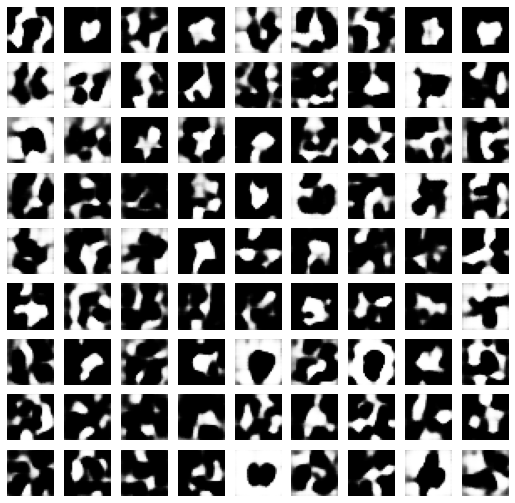

E:1, Loss G:0.6767, Loss D:0.5253, Acc G:%0.94, Acc D:%96.11
E:2, Loss G:0.6843, Loss D:0.5164, Acc G:%0.81, Acc D:%96.89


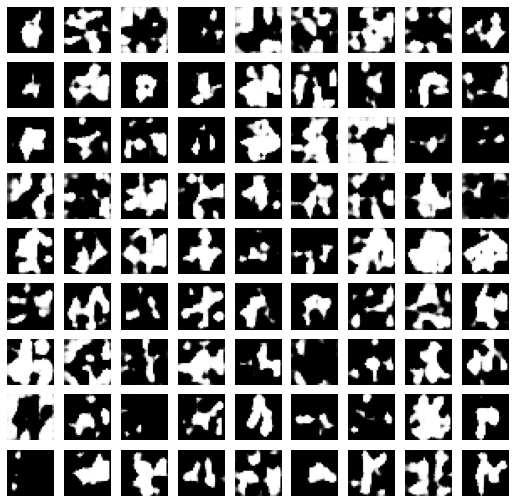

E:3, Loss G:0.6886, Loss D:0.5104, Acc G:%0.66, Acc D:%97.44
E:4, Loss G:0.6892, Loss D:0.5108, Acc G:%0.57, Acc D:%97.72


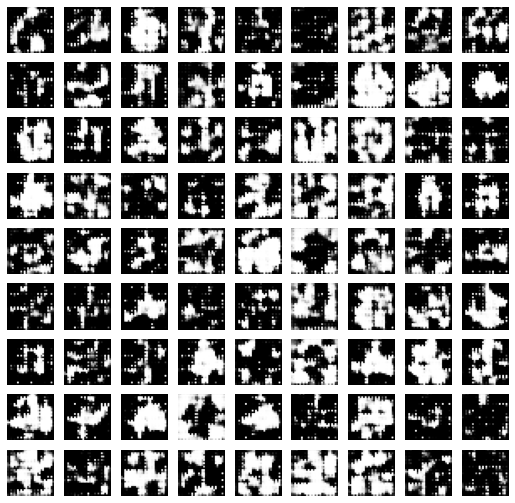

E:5, Loss G:0.6899, Loss D:0.5089, Acc G:%0.49, Acc D:%98.02
E:6, Loss G:0.6892, Loss D:0.5098, Acc G:%0.52, Acc D:%98.09


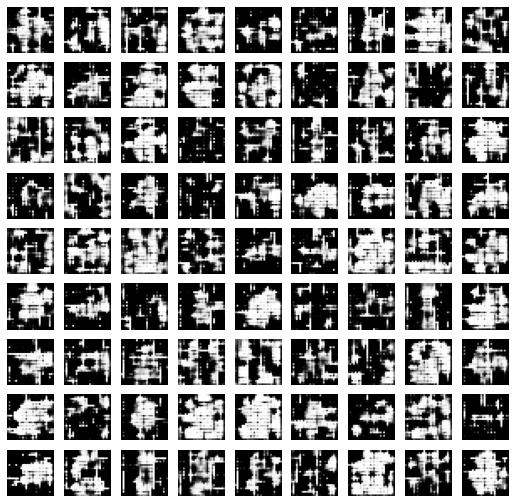

E:7, Loss G:0.6747, Loss D:0.5453, Acc G:%0.58, Acc D:%97.94
E:8, Loss G:0.6443, Loss D:0.6250, Acc G:%1.12, Acc D:%95.99


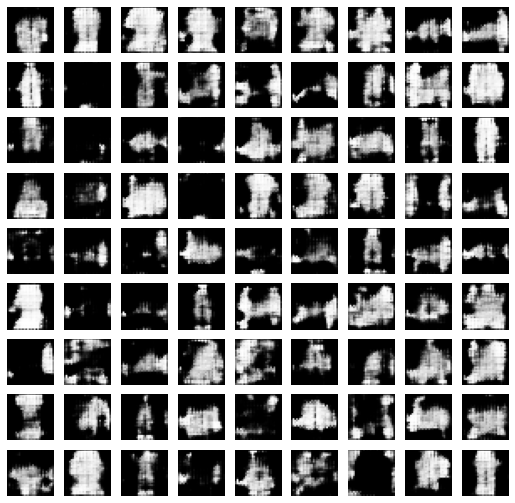

E:9, Loss G:0.6390, Loss D:0.6400, Acc G:%2.07, Acc D:%92.91
E:10, Loss G:0.6406, Loss D:0.6300, Acc G:%2.63, Acc D:%90.71


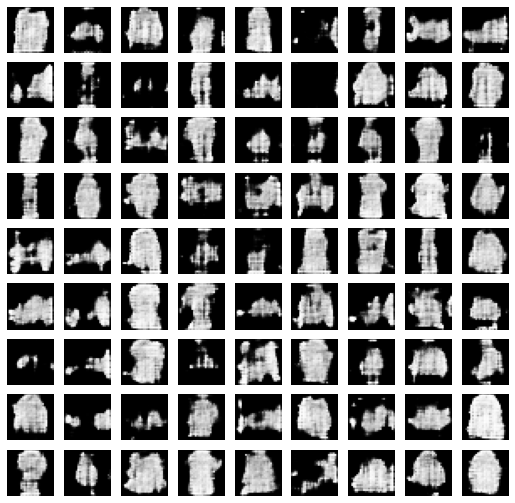

E:11, Loss G:0.6387, Loss D:0.6295, Acc G:%2.96, Acc D:%88.97
E:12, Loss G:0.6359, Loss D:0.6244, Acc G:%3.25, Acc D:%87.58


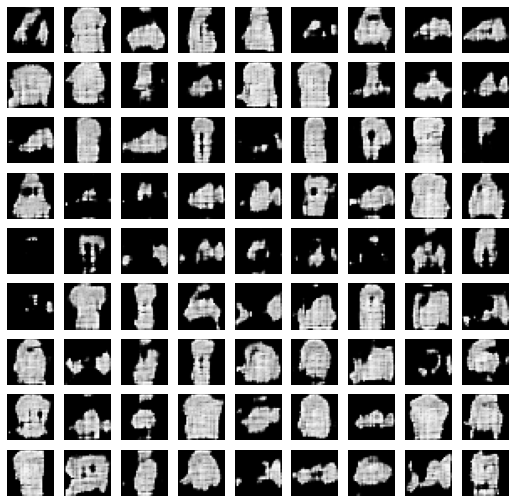

E:13, Loss G:0.6388, Loss D:0.6184, Acc G:%3.44, Acc D:%86.54
E:14, Loss G:0.6378, Loss D:0.6137, Acc G:%3.57, Acc D:%85.77


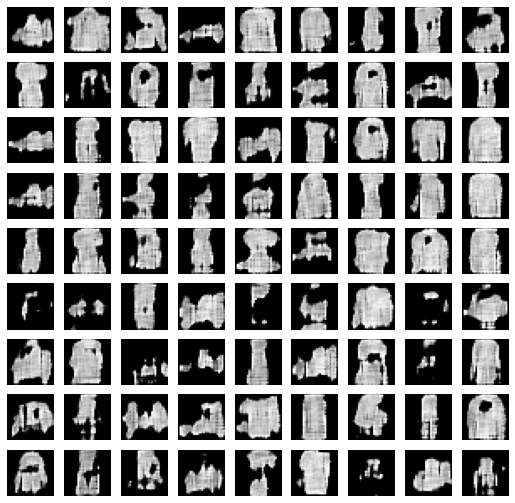

E:15, Loss G:0.6366, Loss D:0.6094, Acc G:%3.71, Acc D:%85.18
E:16, Loss G:0.6388, Loss D:0.6088, Acc G:%3.83, Acc D:%84.72


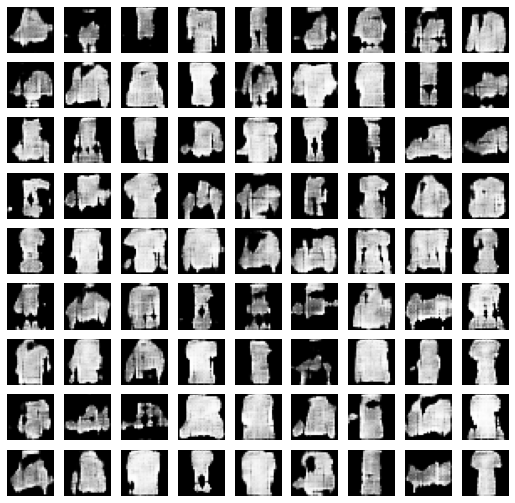

E:17, Loss G:0.6402, Loss D:0.6135, Acc G:%3.95, Acc D:%84.24
E:18, Loss G:0.6415, Loss D:0.6113, Acc G:%4.04, Acc D:%83.77


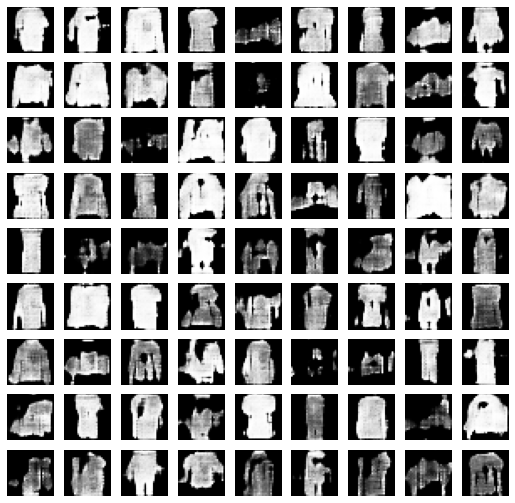

E:19, Loss G:0.6429, Loss D:0.6106, Acc G:%4.11, Acc D:%83.36
E:20, Loss G:0.6442, Loss D:0.6107, Acc G:%4.18, Acc D:%82.98


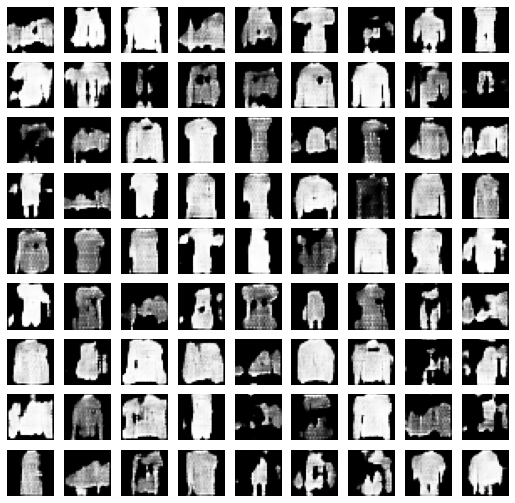

E:21, Loss G:0.6431, Loss D:0.6095, Acc G:%4.24, Acc D:%82.64
E:22, Loss G:0.6425, Loss D:0.6071, Acc G:%4.30, Acc D:%82.35


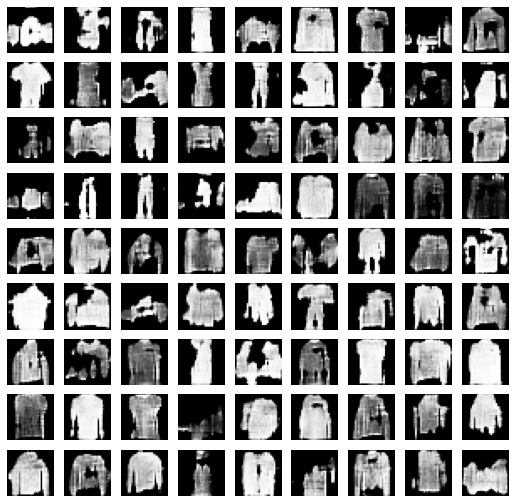

E:23, Loss G:0.6443, Loss D:0.6066, Acc G:%4.35, Acc D:%82.11
E:24, Loss G:0.6456, Loss D:0.6062, Acc G:%4.37, Acc D:%81.88


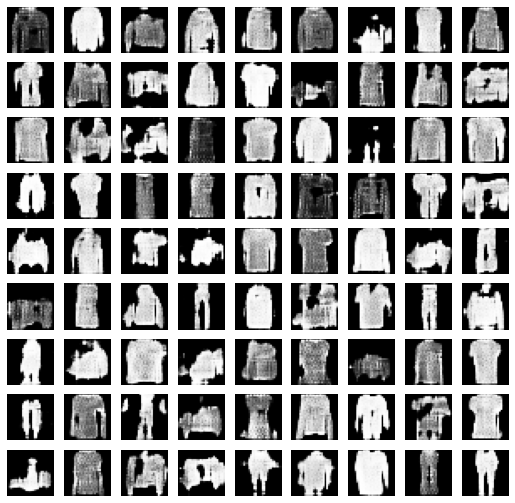

E:25, Loss G:0.6465, Loss D:0.6063, Acc G:%4.38, Acc D:%81.67
E:26, Loss G:0.6480, Loss D:0.6073, Acc G:%4.37, Acc D:%81.46


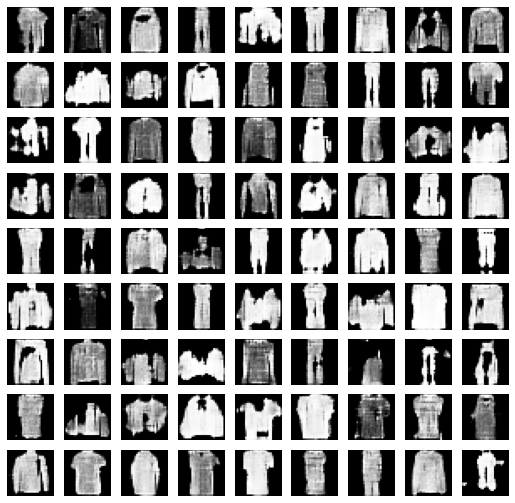

E:27, Loss G:0.6498, Loss D:0.6077, Acc G:%4.35, Acc D:%81.24
E:28, Loss G:0.6515, Loss D:0.6078, Acc G:%4.32, Acc D:%81.03


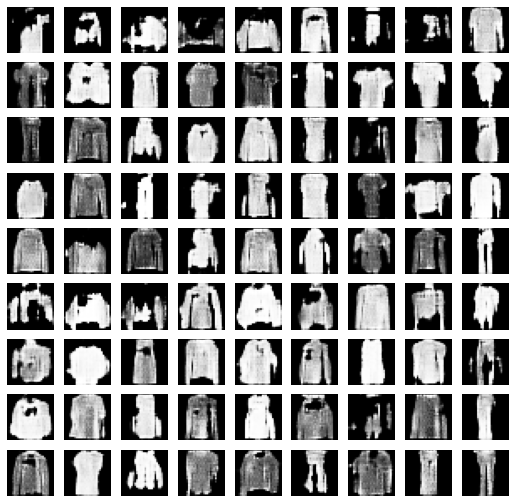

E:29, Loss G:0.6516, Loss D:0.6063, Acc G:%4.29, Acc D:%80.84


In [11]:
for epoch in range(30):

  # accumulate the loss to calculate the average at the end of the epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # loop the dataset one batch at a time
  for batch in dataset:

    # train the discriminator
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # increment the counter
    cnt += 1

  # log the performance
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 2 == 0:
    plotImages(generator)

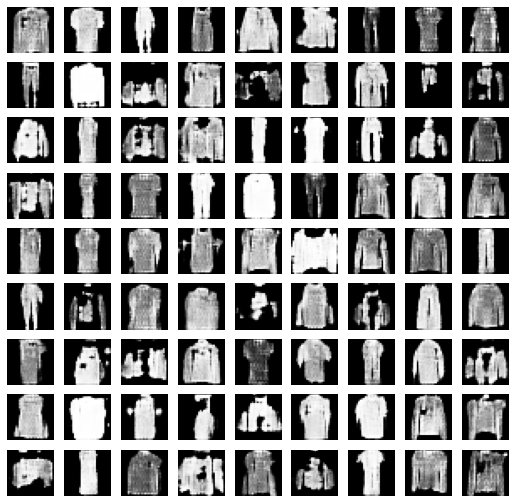

In [12]:
# generate some images with the trained model
images = generator(np.random.normal(size=(81, NOISE_DIM)))

# plot the generated samples
plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();